In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

2024-03-30 17:51:20.419810: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 17:51:20.419857: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 17:51:20.419896: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 17:51:20.428506: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv(r"../unsw_dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv(r"../unsw_dataset/UNSW_NB15_testing-set.csv")


In [3]:
df = pd.concat([train,test])

In [4]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [5]:
df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)  

In [7]:
print(df.duplicated().sum(), "fully duplicate rows to remove")

0 fully duplicate rows to remove


In [8]:
df_encoded = df.copy()

le = LabelEncoder()

df_encoded['attack_cat'] = le.fit_transform(df['attack_cat'])

X = df_encoded.drop('attack_cat', axis=1)
y = df_encoded['attack_cat']

In [9]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# One-hot encode categorical features
categorical_columns = ['proto', 'service', 'state']  # Specify your categorical columns
X = pd.get_dummies(df.drop('attack_cat', axis=1), columns=categorical_columns)
y = df['attack_cat']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)


In [10]:
X_train

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
102468,102469,0.210396,10,10,1000,4664,90.305896,62,252,3.422118e+04,...,False,False,False,True,False,False,False,False,False,False
64802,64803,5.619431,138,38,162294,2612,31.141943,62,252,2.293727e+05,...,False,False,False,True,False,False,False,False,False,False
33634,33635,0.000977,2,2,132,164,3070.624396,31,29,5.404299e+05,...,False,True,False,False,False,False,False,False,False,False
27874,27875,0.037950,60,62,3614,50036,3188.405658,31,29,7.491962e+05,...,False,False,False,True,False,False,False,False,False,False
99000,99001,0.767809,22,30,1040,18514,66.422771,62,252,1.034632e+04,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37547,37548,0.031852,60,62,3598,48710,3798.819605,31,29,8.888610e+05,...,False,False,False,True,False,False,False,False,False,False
21362,21363,0.191118,22,26,2054,2582,245.921365,31,29,8.208541e+04,...,False,False,False,True,False,False,False,False,False,False
49600,49601,1.394700,12,10,2026,788,15.057001,254,252,1.065749e+04,...,False,False,False,True,False,False,False,False,False,False
64535,64536,0.754238,22,36,1040,26328,75.572961,62,252,1.053248e+04,...,False,False,False,True,False,False,False,False,False,False


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


In [11]:
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ["gini", "entropy"]

}


In [12]:
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)


In [13]:
grid_search.fit(X_train_scaled, y_train_encoded)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=5; total time=   4.7s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   5.3s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   5.6s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=10; total time=   5.5s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=10; total time=   5.5s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=2; total time=   5.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   5.7s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=2; total time=   5.5s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=2; total time=   5.6s
[CV] END criterion=gini, max_depth=10, min_s

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [15]:
best_grid = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")


Best parameters found: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [16]:
best_dt = DecisionTreeClassifier(**grid_search.best_params_, random_state=42)
best_dt.fit(X_train_scaled, y_train_encoded)



DecisionTreeClassifier(max_depth=20, random_state=42)

In [17]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = best_dt.predict(X_test_scaled)
print(classification_report(y_test_encoded, y_pred))
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred)}")


              precision    recall  f1-score   support

           0       0.62      0.20      0.31       538
           1       0.48      0.15      0.23       471
           2       0.42      0.38      0.40      3293
           3       0.69      0.81      0.74      8853
           4       0.88      0.88      0.88      4742
           5       0.99      0.98      0.99     11849
           6       1.00      1.00      1.00     18675
           7       0.90      0.76      0.83      2770
           8       0.65      0.60      0.63       318
           9       0.46      0.62      0.52        26

    accuracy                           0.88     51535
   macro avg       0.71      0.64      0.65     51535
weighted avg       0.88      0.88      0.88     51535

Accuracy: 0.8805277966430581


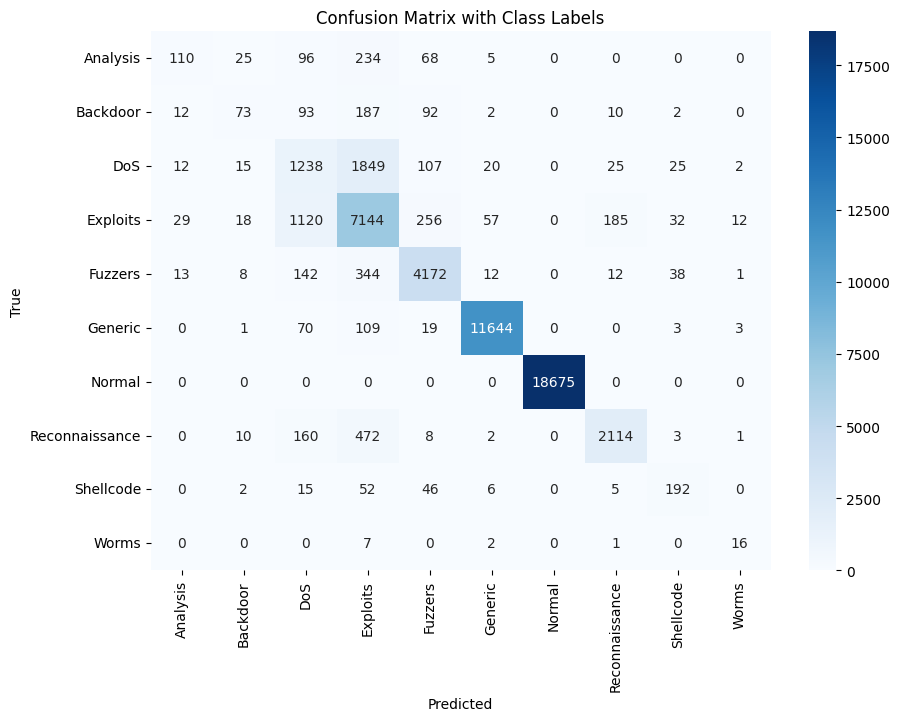

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_encoded, y_pred)

class_names = label_encoder.classes_

# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Class Labels')
plt.show()


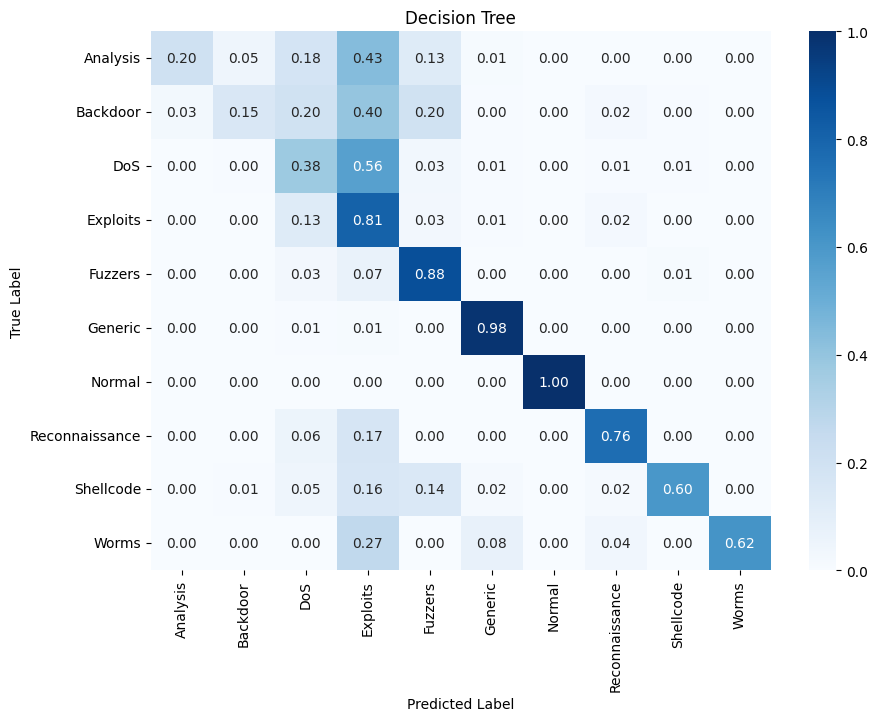

In [19]:
# Normalize the confusion matrix by rows
row_sums = cm.sum(axis=1)
conf_matrix_normalized = cm / row_sums[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)  # Use fmt=".2f" to format the numbers
plt.title("Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [23]:
from sklearn.metrics import precision_recall_fscore_support,accuracy_score



# Compute weighted average precision, recall, f1-score
precision_weighted, recall_weighted, f1_score_weighted, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='weighted')
print(f"Weighted Average Precision: {precision_weighted:.4f}")
print(f"Weighted Average Recall: {recall_weighted:.4f}")
print(f"Weighted Average F1-Score: {f1_score_weighted:.4f}")

# Compute micro average precision, recall, f1-score
precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='macro')
print(f"Micro Average Precision: {precision_micro:.4f}")
print(f"Micro Average Recall: {recall_micro:.4f}")
print(f"Micro Average F1-Score: {f1_score_micro:.4f}")
accuracy = accuracy_score(y_test_encoded, y_pred)
# Print overall accuracy
print(f"Overall Accuracy: {accuracy:.4f}")


Weighted Average Precision: 0.8792
Weighted Average Recall: 0.8805
Weighted Average F1-Score: 0.8768
Micro Average Precision: 0.7087
Micro Average Recall: 0.6387
Micro Average F1-Score: 0.6523
Overall Accuracy: 0.8805


Sampling minority classes

In [37]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [38]:
train = pd.read_csv(r"../unsw_dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv(r"../unsw_dataset/UNSW_NB15_testing-set.csv")


In [39]:
df = pd.concat([train,test])

In [40]:
df_encoded = df.copy()

le = LabelEncoder()

df_encoded['attack_cat'] = le.fit_transform(df['attack_cat'])

X = df_encoded.drop('attack_cat', axis=1)
y = df_encoded['attack_cat']

In [41]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

categorical_columns = ['proto', 'service', 'state'] 
X = pd.get_dummies(df.drop('attack_cat', axis=1), columns=categorical_columns)
y = df['attack_cat']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import pandas as pd

In [43]:
# Define the sampling strategies
sampling_strategy_over = {
    "Generic": 50000,
    "Exploits": 45000,
    "Fuzzers": 25000,
    "DoS": 15000,
    "Reconnaissance": 12000,
    "Analysis": 3000,
    "Backdoor": 2000,
    "Shellcode": 2000,
    "Worms": 500
}

sampling_strategy_under = {
    "Normal": 70000
}

# Apply SMOTE for oversampling and RandomUnderSampler for downsampling
over = SMOTE(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)

In [44]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res = under.fit_resample(X_train_res, y_train_res)

print(y_train_res.value_counts())

attack_cat
Normal            70000
Generic           50000
Exploits          45000
Fuzzers           25000
DoS               15000
Reconnaissance    12000
Analysis           3000
Backdoor           2000
Shellcode          2000
Worms               500
Name: count, dtype: int64


In [45]:


# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_res)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)


In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


In [47]:
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ["gini", "entropy"]

}


In [48]:
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)


In [49]:
grid_search.fit(X_train_scaled, y_train_encoded)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=10; total time=   4.9s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   5.0s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   5.0s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   5.0s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   5.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=10; total time=   5.2s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   6.0s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=5; total time=   6.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=5; total time=   6.1s
[CV] END criterion=gini, max_depth=10, min_

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [50]:
best_grid = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")


Best parameters found: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [51]:
best_dt = DecisionTreeClassifier(**grid_search.best_params_, random_state=42)
best_dt.fit(X_train_scaled, y_train_encoded)



DecisionTreeClassifier(max_depth=20, min_samples_split=5, random_state=42)

In [52]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = best_dt.predict(X_test_scaled)
print(classification_report(y_test_encoded, y_pred))
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred)}")


              precision    recall  f1-score   support

           0       0.50      0.19      0.28       538
           1       0.47      0.14      0.22       471
           2       0.40      0.34      0.37      3293
           3       0.68      0.80      0.74      8853
           4       0.87      0.88      0.87      4742
           5       0.99      0.98      0.99     11849
           6       1.00      1.00      1.00     18675
           7       0.89      0.76      0.82      2770
           8       0.63      0.65      0.64       318
           9       0.40      0.54      0.46        26

    accuracy                           0.88     51535
   macro avg       0.68      0.63      0.64     51535
weighted avg       0.87      0.88      0.87     51535

Accuracy: 0.8777917919860289


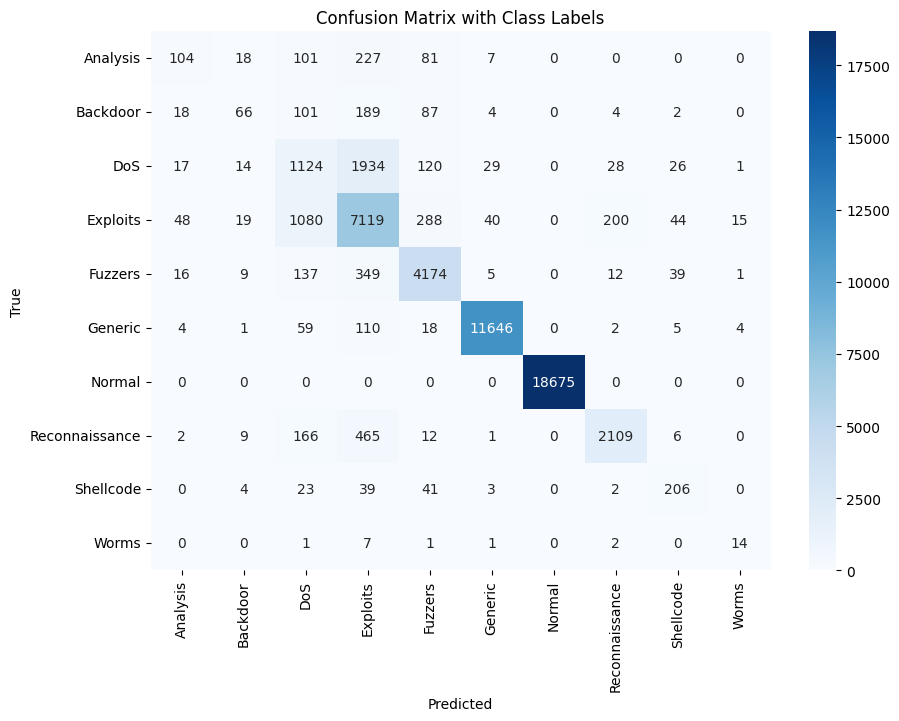

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_encoded, y_pred)

class_names = label_encoder.classes_

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Class Labels')
plt.show()


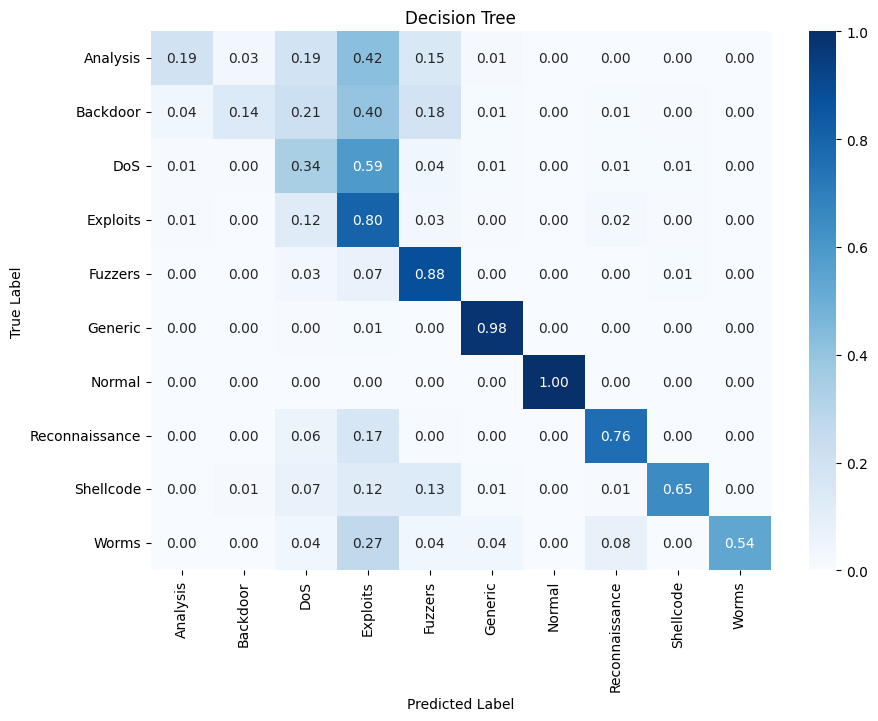

In [54]:
# Normalize the confusion matrix by rows
row_sums = cm.sum(axis=1)
conf_matrix_normalized = cm / row_sums[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)  # Use fmt=".2f" to format the numbers
plt.title("Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [55]:
from sklearn.metrics import precision_recall_fscore_support,accuracy_score

# Compute weighted average precision, recall, f1-score
precision_weighted, recall_weighted, f1_score_weighted, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='weighted')
print(f"Weighted Average Precision: {precision_weighted:.4f}")
print(f"Weighted Average Recall: {recall_weighted:.4f}")
print(f"Weighted Average F1-Score: {f1_score_weighted:.4f}")

# Compute micro average precision, recall, f1-score
precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='macro')
print(f"Micro Average Precision: {precision_micro:.4f}")
print(f"Micro Average Recall: {recall_micro:.4f}")
print(f"Micro Average F1-Score: {f1_score_micro:.4f}")
accuracy = accuracy_score(y_test_encoded, y_pred)
# Print overall accuracy
print(f"Overall Accuracy: {accuracy:.4f}")


Weighted Average Precision: 0.8747
Weighted Average Recall: 0.8778
Weighted Average F1-Score: 0.8734
Micro Average Precision: 0.6834
Micro Average Recall: 0.6290
Micro Average F1-Score: 0.6382
Overall Accuracy: 0.8778
